In [1]:
import sys
import gpytorch
import numpy as np
import pandas as pd
import torch
from datetime import datetime
from scipy.stats import qmc
import itertools
from itertools import combinations_with_replacement, combinations, permutations

import bo_methods_lib
from bo_methods_lib.bo_methods_lib.GPBO_Classes_New import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Class_fxns import * #Fix this later
from bo_methods_lib.bo_methods_lib.analyze_data import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Classes_plotters import * #Fix this later
import pympler
import pickle

from pympler import asizeof

from matplotlib import pyplot as plt

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#From signac
import signac
date_time_str = None
meth_name_str_list = [1, 2, 3, 4, 5]
study_id = "ep"
save_csv = False


criteria_dict = {"cs_name_val" : 2,
                 "param_name_str" : "a",
                 "retrain_GP": 5,
                 "num_x_data": 5,
                 "num_val_pts": 0}

df = pd.DataFrame()
job_list = []
for meth_name_val in meth_name_str_list:
    criteria_dict["meth_name_val"] = meth_name_val
    df_piece, jobs, name_cs_str, theta_true = get_study_data_signac(criteria_dict, study_id, save_csv)
    job_list += [job for job in jobs]
#     df_best = get_best_data(df_piece, study_id, name_cs_str, theta_true, param_name_str, date_time_str, save_csv)
    df = pd.concat([df, df_piece], ignore_index=True)
    
# df = df[df['EP Method Val'] == 4]

In [3]:
### Get Best Data from ep experiment
save_csv = False
df_best = get_best_data(df, study_id, name_cs_str, theta_true, job_list, date_time_str, save_csv)
df_best

# save_path = "Results/" + study_id + "_study/" + cs_name + "/" + param_name_str + "/" +  study_id + "_study_best.csv"
# df_best.to_csv(save_path, header = True)
# #Get Mean Data from ep experiment
# df_mean = get_mean_data(df, study_id, name_cs_str, theta_true, param_name_str, date_time_str, save_csv)
# df_mean

# #Get Median Data from ep experiment
# df_median = get_median_data(df, study_id, name_cs_str, theta_true, param_name_str, date_time_str, save_csv)

# #Get Median of Best Data from ep experiment
# df_median_best = get_median_data(df_best, study_id, name_cs_str, theta_true, param_name_str, date_time_str, save_csv)
# df_median_best

,Run Number,BO Iter,Best Error,Exploration Bias,Max EI,Theta Max EI,Min Obj,Min Obj Act,Theta Min Obj,Min Obj Cum.,Theta Min Obj Cum.,Time/Iter,EP Method Val,BO Method,Max Evals,Total Run Time,L2 Norm Theta
25,12,1,1585612.912573,1.0,0.0,"[-0.6274048388613718, -0.20070918286031647, -3...",-586160845.928586,2070586.273524,"[-0.7489732164629821, -2.0, -5.486214995235525...",2070586.273524,"[-0.7489732164629821, -2.0, -5.486214995235525...",0.263479,1,A1,2,0.526959,1.509500
30,0,0,14.276482,1.0,3.052607,"[-0.7518875176515021, -2.0, -5.929291481636396...",10.748305,23.565407,"[-2.0, -2.0, -2.220446049250313e-16, -2.0]",23.565407,"[-2.0, -2.0, -2.220446049250313e-16, -2.0]",0.475232,1,B1,3,1.425696,7.179136
137,1,29,14739.635804,1.0,367483.693662,"[-1.5249414797431173, -0.64645343352516, -6.76...",887.783125,935.153071,"[-1.5248081572739005, -0.8447617884110251, -6....",935.153071,"[-1.5248081572739005, -0.8447617884110251, -6....",329.844787,1,A2,36,11874.412336,0.555456
1084,14,8,14.276482,1.0,342.635558,"[-0.4077083808500539, 0.9511550772914474, -3.0...",10.144574,10.460133,"[-0.7936217690594068, -1.1283420780214681, -4....",10.460133,"[-0.7936217690594068, -1.1283420780214681, -4....",45.550071,1,B2,33,1503.152351,1.961218
1137,14,0,1585612.912573,1.0,0.0,"[-0.5376238501428094, -1.5420921394617464, -3....",58972.050669,1190320.897549,"[-0.07504339235716248, 1.0001027774818383, -9....",1190320.897549,"[-0.07504339235716248, 1.0001027774818383, -9....",41.026716,1,C2,2,82.053431,3.479919


In [4]:
#Get only the jobs which are the best
project = signac.get_project()
job_list_best = []
for meth_name_val in meth_name_str_list:
    #Get best ep data from previous results if possible    
    criteria_dict_ep = criteria_dict.copy()
    criteria_dict_ep["meth_name_val"] = meth_name_val
    criteria_dict_ep["sep_fact"] = 1.0
    meth_name = Method_name_enum(meth_name_val).name
    
    path_name = job_list[0].fn(study_id + "_study_best_all.csv")
    df_ep_best = pd.read_csv(path_name, header = 0)
    best_ep_enum_val = int(df_ep_best["EP Method Val"][(df_ep_best['BO Method'] == meth_name)])
    criteria_dict_ep["ep_enum_val"] = best_ep_enum_val
    
    #Get all jobs with that ep enum val
    jobs_best = project.find_jobs(criteria_dict_ep)
    job_list_best += [job for job in jobs_best]

for i in range(len(job_list_best)): 
    print(job_list_best[i].id)

70675d99c60cfdc559a54f0e226bf8d1
3250e2f6acbc5663261af645b193d9d1
3805491fd54c1135117f1ece1e600227
2ed82c17d8fa2944f07bd6b575f31602
62090761691c961bf86907e9b01b3e3e


/scratch365/mcarlozo/Toy_Problem/bo_methods_lib/bo_methods_lib/analyze_data.py:827: RuntimeWarning: invalid value encountered in log
  heat_map_data.sse = np.log(heat_map_data.sse)


KeyboardInterrupt: 

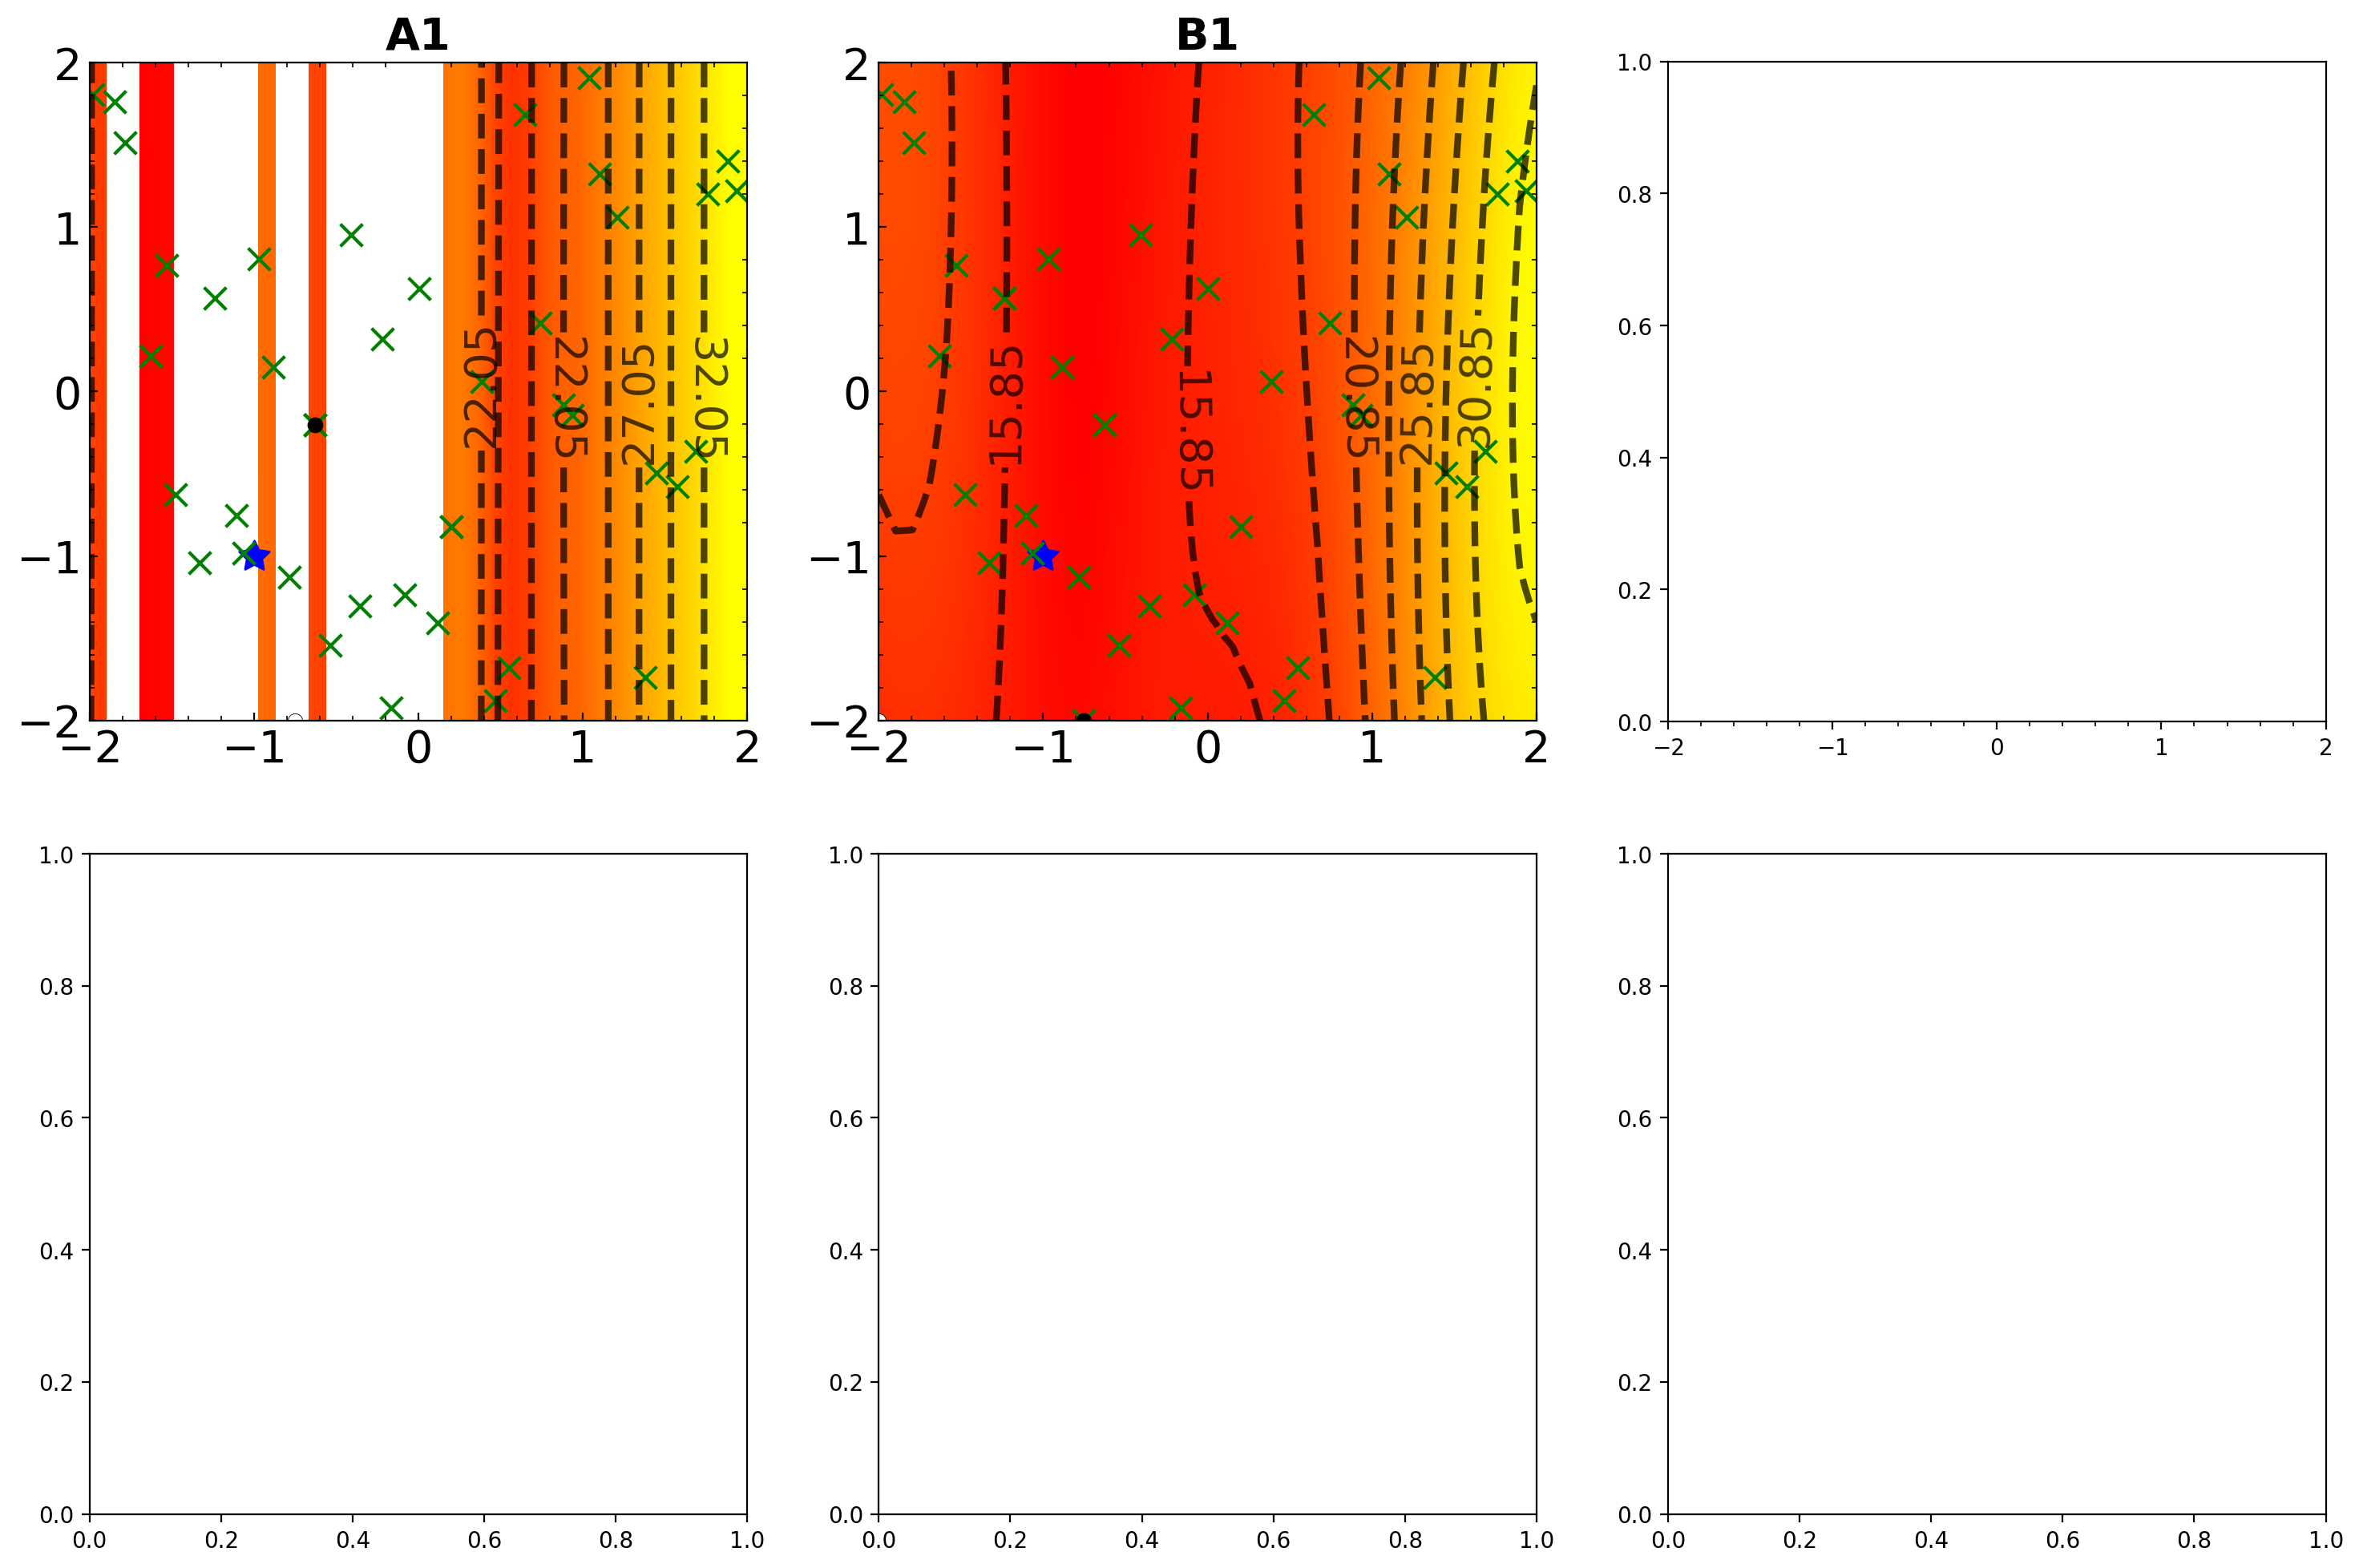

In [5]:
title_fontsize = 24
other_fontsize = 20
xbins = 4
ybins = 5
zbins = 900
save_path = None
cmap = "autumn"
pair = 0
log_data = True

title = "Heat Map Pair "
z_choice = "sse_mean"
title = "Heat Map Pair " + z_choice
title = None
levels = [100,100,100, 100, 100]
run_num_list = list(map(int, df_best["Run Number"].to_numpy() + 1))
bo_iter_list = list(map(int, df_best["BO Iter"].to_numpy() + 1))

meth_name_str_list = ["A1", "B1", "A2", "B2", "C2"]

pair = 0

file_path_list = [job.fn("BO_Results.gz") for job in job_list_best]

compare_method_heat_maps(file_path_list, meth_name_str_list, run_num_list, bo_iter_list, pair, 
                         z_choice, log_data, levels, xbins, ybins, zbins, title, title_fontsize, other_fontsize, 
                         cmap, save_path)

In [ ]:
bo_method_list = ["A1", "B1", "A2", "B2", "C2" ]
run_num_list = list(map(int, df_best["Run Number"].to_numpy() + 1))
data_names = ["EI"]
string_for_df_theta = ["Min Obj Cum."]
# data_names = ["log(sse)", "min(log(sse))", "log(EI)"]

title_fontsize = 24
other_fontsize = 20
xbins = 5
ybins = 7
x_label = "BO Iterations"
y_label = "Data"
title = "Min SSE Values"
save_path = None
log_data = False

file_path_list = [job.fn("BO_Results.gz") for job in job_list_best]

plot_compare_method_ei_sse(file_path_list, bo_method_list, run_num_list, string_for_df_theta, data_names, xbins, ybins, 
                                   title, x_label, y_label, log_data, title_fontsize, other_fontsize, save_path)

In [ ]:
#Plot Muller potential
project = signac.get_project()
for meth_val in meth_name_str_list:
    criteria_dict["meth_name_val"] = meth_val
    jobs = project.find_jobs(criteria_dict) 
    for job in jobs:
        file_path = job.fn("BO_Results.gz")

    loaded_results = open_file_helper(file_path)
    meth_name = Method_name_enum(loaded_results[0].configuration["Method Name Enum Value"]).name


    run_num = df_best.loc[df_best['BO Method'].str.contains(meth_name), 'Run Number'].iloc[0] + 1
    bo_iter = df_best.loc[df_best['BO Method'].str.contains(meth_name), 'BO Iter'].iloc[0] + 1
    trained_hps = loaded_results[run_num-1].list_gp_emulator_class[bo_iter-1].trained_hyperparams
    print("Method: ", meth_name)
    print("Run Number: ", run_num)
    print("BO Iter Number: ", bo_iter)
    print("Trained Hyperparameters: ", trained_hps)
    x_val_num = 20
    theta_choice = None
    theta_true = loaded_results[run_num-1].simulator_class.theta_true
    theta_choice = theta_true
    seed = loaded_results[0].configuration["Seed"]

    title_fontsize = 24
    other_fontsize = 20
    xbins = 4
    ybins = 5
    zbins = 900
    save_path = None
    cmap = "autumn"
    save_path = None

    data_vals = compare_muller_heat_map(file_path, run_num, bo_iter, x_val_num, theta_choice, seed)
    test_mesh, y_sim, gp_mean, gp_var, theta_value, train_X, idcs_to_plot = data_vals
    title = "Heat Map For Theta = " + str(np.round(theta_value,1))

    z = [y_sim,  gp_mean, gp_var]
    z_titles = ["y_sim" , "y_gp", "y_var"]
    cmap = "jet"
    levels = [100,100,100]
    plot_axis_names = ["X1", "X2"]

    plot_heat_maps(test_mesh, None, None, None, train_X, plot_axis_names, levels, idcs_to_plot, z, 
                   z_titles, xbins, ybins, zbins, title, title_fontsize, other_fontsize, cmap, save_path)